<a href="https://colab.research.google.com/github/Nik8x/Skin_Cancer_HAM10000_dataset/blob/master/Skin_Cancer_HAM10000_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Our task to is detect 7 different classes of skin cancer using CNN 

In [0]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use("ggplot")

import glob

from skimage import io
from skimage.transform import resize  # to resize images

from scipy.stats import randint
from scipy.stats import skew

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

#import tensorflow as tf

import xgboost as xgb

import math as math

#!pip install pandas_profiling
import pandas_profiling as pp

import time

Using TensorFlow backend.


[The HAM10000 dataset information and download link](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T)

[Skin Cancer MNIST: HAM10000 Kaggle Link](https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000)

In [0]:
cancer = pd.read_csv("https://dataverse.harvard.edu/api/access/datafile/3172582?format=original&gbrecs=true")
cancer.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [0]:
pp.ProfileReport(cancer.drop(['lesion_id', 'image_id'], axis = 1))

In [0]:
cancer.shape

(10015, 7)

In [0]:
# we have 10015 images, which are available in two seperate folders

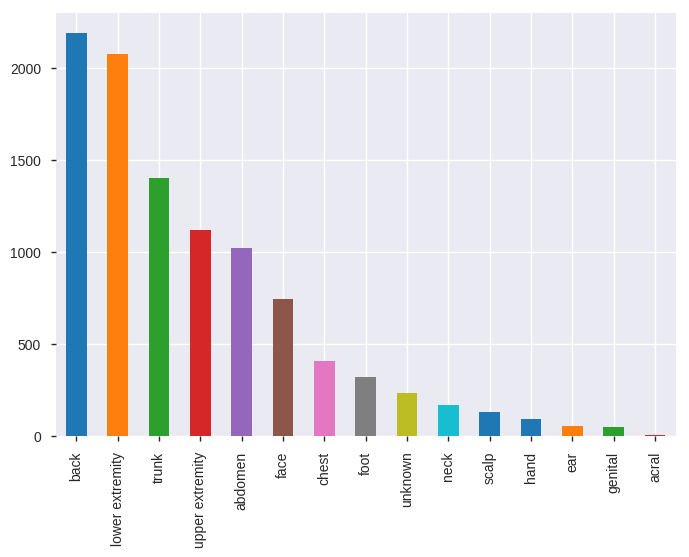

In [0]:
cancer.localization.value_counts().plot.bar()
plt.show()

In [0]:
# It looks like more than 1000 patients have back , lower extremity, trunk, upper extremity 
# and abdomen region skin cancer

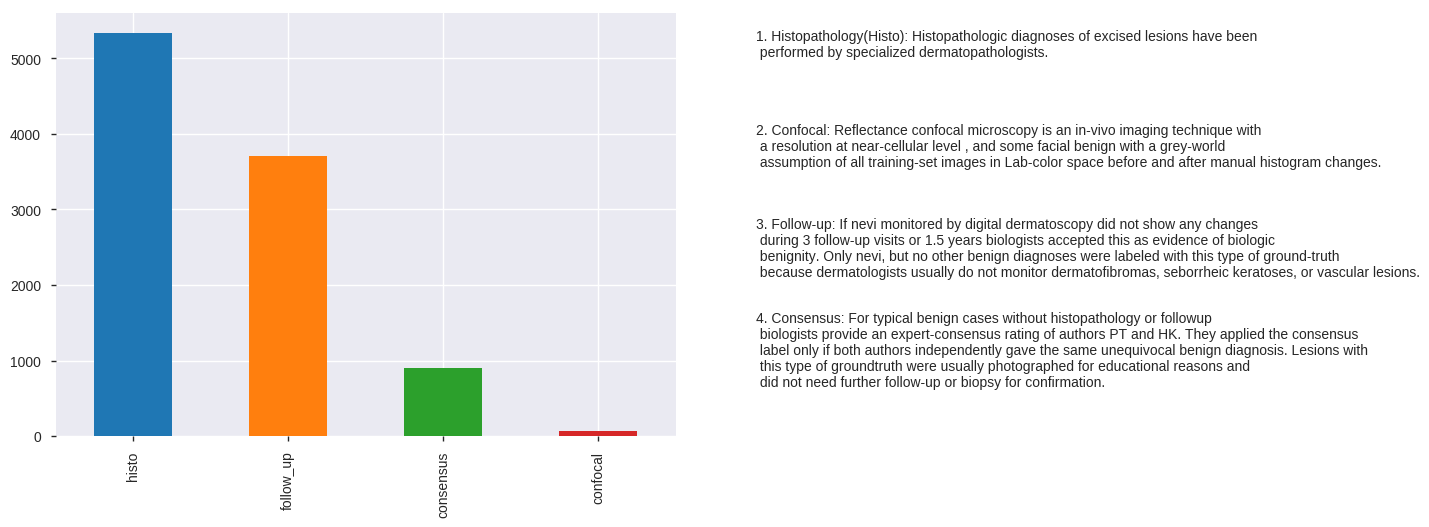

In [0]:
cancer.dx_type.value_counts().plot.bar()
plt.figtext(1, .80,'1. Histopathology(Histo): Histopathologic diagnoses of excised lesions have been \n performed by specialized dermatopathologists.')
plt.figtext(1, .60,'2. Confocal: Reflectance confocal microscopy is an in-vivo imaging technique with \n a resolution at near-cellular level , and some facial benign with a grey-world \n assumption of all training-set images in Lab-color space before and after manual histogram changes.')
plt.figtext(1, .40,'3. Follow-up: If nevi monitored by digital dermatoscopy did not show any changes \n during 3 follow-up visits or 1.5 years biologists accepted this as evidence of biologic \n benignity. Only nevi, but no other benign diagnoses were labeled with this type of ground-truth \n because dermatologists usually do not monitor dermatofibromas, seborrheic keratoses, or vascular lesions.')
plt.figtext(1, .20,'4. Consensus: For typical benign cases without histopathology or followup \n biologists provide an expert-consensus rating of authors PT and HK. They applied the consensus \n label only if both authors independently gave the same unequivocal benign diagnosis. Lesions with \n this type of groundtruth were usually photographed for educational reasons and \n did not need further follow-up or biopsy for confirmation.')
plt.show()

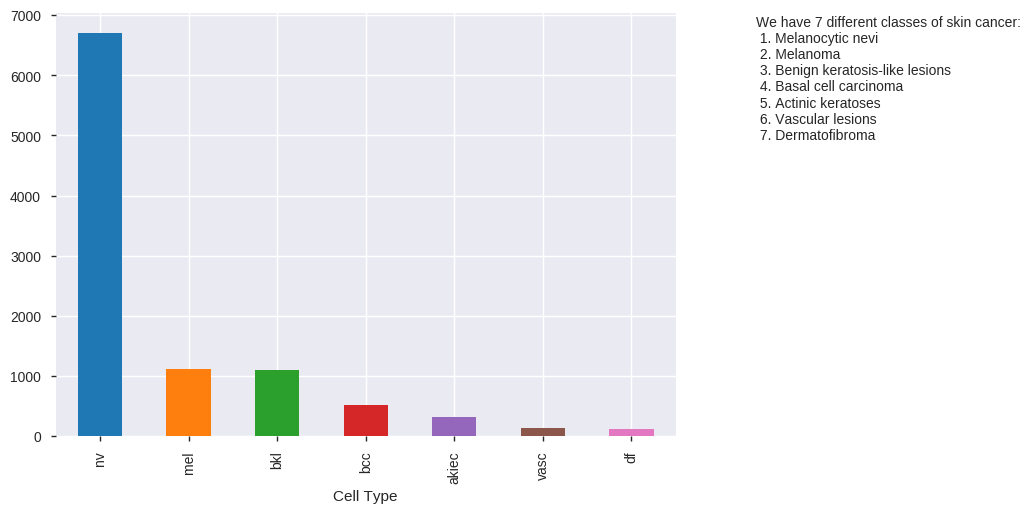

In [0]:
cancer.dx.value_counts().plot.bar()
plt.xlabel('Cell Type')
plt.figtext(1, .65, 'We have 7 different classes of skin cancer: \n 1. Melanocytic nevi \n 2. Melanoma \n 3. Benign keratosis-like lesions \n 4. Basal cell carcinoma \n 5. Actinic keratoses \n 6. Vascular lesions \n 7. Dermatofibroma')
plt.show()

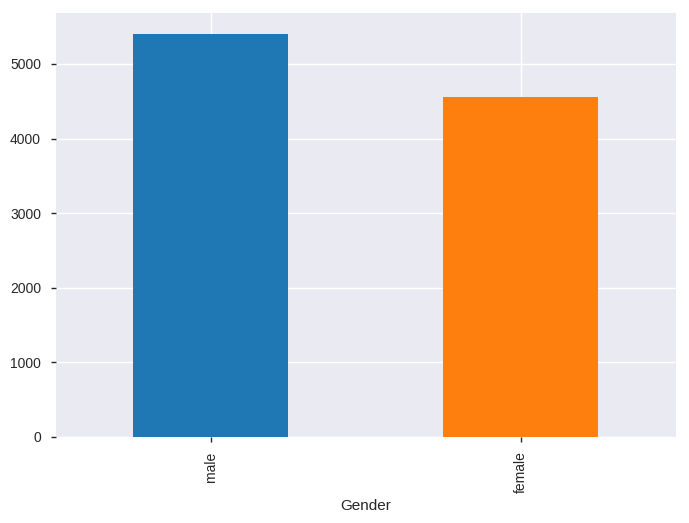

In [0]:
cancer.sex.value_counts()[0:2].plot.bar()
plt.xlabel('Gender')
plt.show()

In [0]:
# let's look at any missing data

In [0]:
pd.DataFrame(cancer.isnull().sum()).T

lesion_id  image_id  dx  dx_type  age  sex  localization
0          0         0   0        0   57    0             0

In [0]:
# filling missing age column with mean values
cancer.age.fillna((cancer.age.mean()), inplace = True)

In [0]:
cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
lesion_id       10015 non-null object
image_id        10015 non-null object
dx              10015 non-null object
dx_type         10015 non-null object
age             10015 non-null float64
sex             10015 non-null object
localization    10015 non-null object
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


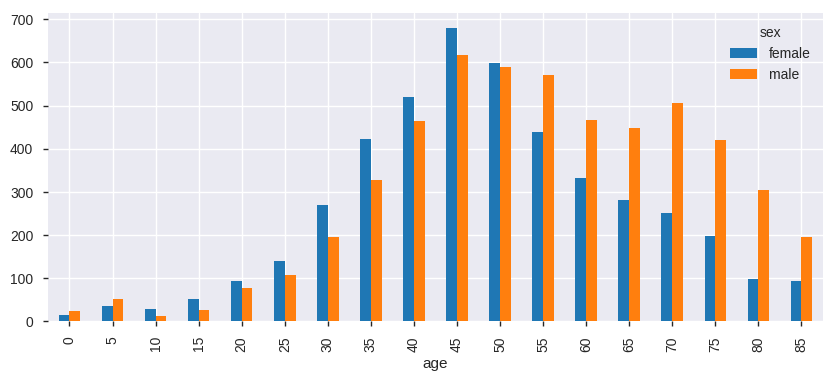

In [0]:
pd.crosstab(cancer.age.astype(int), cancer.sex).drop('unknown', axis = 1).drop(51).plot.bar(figsize=(10, 4))
plt.show()

# here I dropped some unknown data and age of 51 which was having negligible data

In [0]:
# we observe a clear pattern above 25-30 year of age, and also initially females are more prone to
# skin cancer, for that we should look at the cancer type for feamles across age.
# then we observe males are more prone to cancer whose age is more than 50 years, that can also be
# observed in new plot clearly

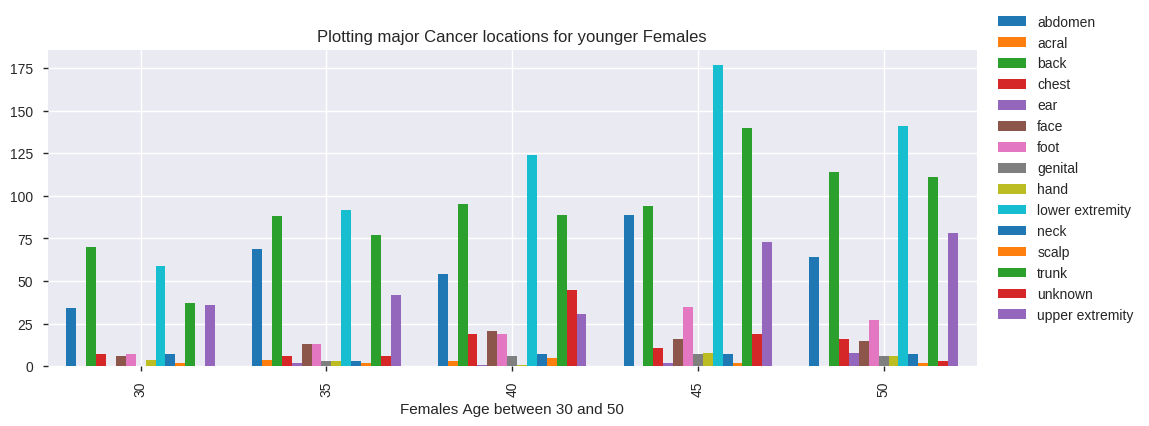

In [0]:
pd.crosstab(cancer.age.astype(int)[cancer.sex == 'female'], cancer.localization[cancer.sex == 'female']).plot.bar(figsize=(10, 4), width=0.8)
plt.xlim(5.5, 10.5)
plt.legend(bbox_to_anchor=(1.01, 0.1))
plt.tight_layout()
plt.xlabel('Females Age between 30 and 50')
plt.title('Plotting major Cancer locations for younger Females')
plt.show()

In [0]:
# we can observe that most of the younger females suffer from cancer in abdomen, back, lower extremity,
# trunk and upper extremity

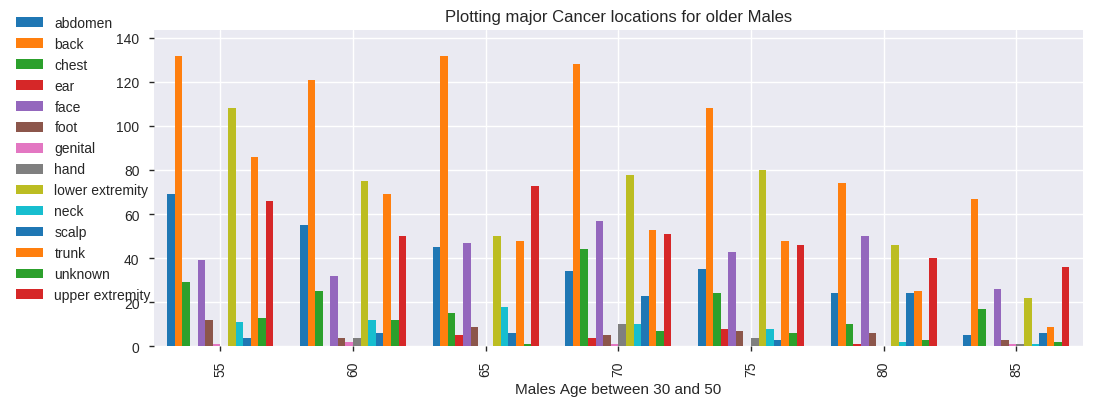

In [0]:
pd.crosstab(cancer.age.astype(int)[cancer.sex == 'male'], cancer.localization[cancer.sex == 'male']).plot.bar(figsize = (10, 4), width = 0.8)
plt.xlim(11.5, 18.5)
plt.legend(bbox_to_anchor=(0.01, 0.1))
plt.tight_layout()
plt.xlabel('Males Age between 30 and 50')
plt.title('Plotting major Cancer locations for older Males')
plt.show()

In [0]:
# we can observe that most of the older males suffer from cancer in back, face, lower extremity,
# trunk and upper extremity

In [0]:
# Sorting the cancer data with image_id and splitting it into train and test dataframe

In [0]:
train = cancer.sort_values('image_id')[0:5000]
test = cancer.sort_values('image_id')[5000:]

In [0]:
# convert dx column to categorical labels

In [0]:
le = preprocessing.LabelEncoder()
# train 
y_train = le.fit_transform(train.dx)

#test
y_test = le.fit_transform(test.dx)

In [0]:
# we can use io.imread() to read the file in jupyter notebook

In [0]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Skin Cancer MNIST HAM10000")
!ls

HAM10000_metadata.csv  hmnist_8_8_L.csv    imagefolder_2
hmnist_28_28_L.csv     hmnist_8_8_RGB.csv  my_model.h5
hmnist_28_28_RGB.csv   imagefolder_1	   Skin_Cancer_HAM10000_dataset.ipynb


In [0]:
img = io.imread('imagefolder_1/ISIC_0024306.jpg')
print(img.shape)

(450, 600, 3)


In [0]:
# this is an array, let's view the plot

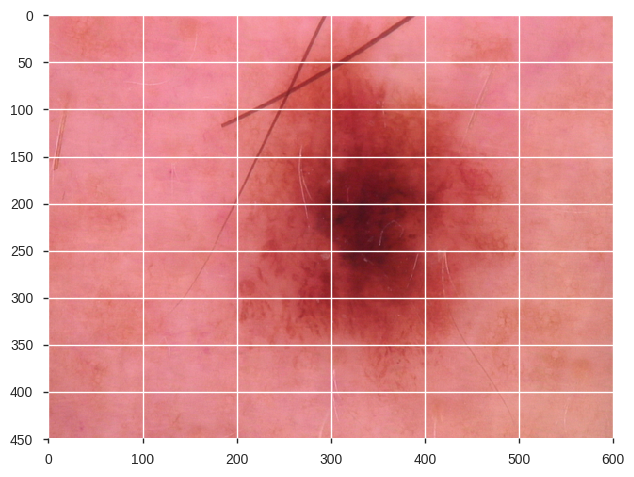

In [0]:
plt.imshow(img)
plt.show()

In [0]:
# let's load all the images by first looking in the directory using glob()

In [0]:
images_train = sorted(glob.glob("imagefolder_1/*.jpg"))
images_test = sorted(glob.glob("imagefolder_2/*.jpg"))

In [0]:
# storing all the image arrays in the list, then converting to series, and then storing to dataframe

In [0]:
start_time = time.clock()

from PIL import Image
import glob

image_train = []
for filename in glob.glob('imagefolder_1/*.jpg'): 
    im = Image.open(filename)
    image_train.append(np.asarray(im))
    
image_test = []
for filename in glob.glob('imagefolder_2/*.jpg'):
    im = Image.open(filename)
    image_test.append(np.asarray(im))
    
print(time.clock() - start_time, "seconds")

131.371062 seconds


In [0]:
images_1_train = np.array(pd.Series(image_train))
images_1_test = np.array(pd.Series(image_test))

In [0]:
# so our dataframe now has the images in array format,
# also look at some of the images and their classes/labels

In [0]:
img_lab = pd.DataFrame({'labels' : train.dx.tolist(), 'image' : image_train})
img_lab.head()

image labels
0  [[[195, 171, 185], [194, 170, 184], [194, 170,...     nv
1  [[[209, 146, 177], [211, 151, 177], [211, 148,...     nv
2  [[[173, 127, 129], [170, 126, 127], [172, 121,...     nv
3  [[[178, 148, 182], [173, 146, 179], [172, 145,...     nv
4  [[[245, 184, 202], [244, 185, 205], [243, 184,...    mel

In [0]:
pd.DataFrame(img_lab['labels'].value_counts()).T

nv  bkl  mel  bcc  akiec  vasc  df
labels  3431  564  435  266    183    65  56

In [0]:
mlist = {1 : 'Melanocytic nevi', 2 : 'Melanoma', 3 : 'Benign keratosis-like lesions', 4 : 'Basal cell carcinoma', 
        5 : 'Actinic keratoses', 6 : 'Vascular lesions', 7 : 'Dermatofibroma'}
def plot_array(a, b, c, d):
    plt.subplot(1, 3, 1)
    plt.imshow(img_lab['image'][a].iloc[b])
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(img_lab['image'][a].iloc[c])
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(img_lab['image'][a].iloc[d])
    plt.axis('off')
    
def plot_array_sub():
    for i in range(0,7):
        plt.figure(figsize = (12, 6))
        plt.subplot(4, 2, i + 1)
        plot_array(img_lab['labels'] == pd.DataFrame(img_lab['labels'].value_counts()).T.columns[i], 0, 1, 2)
        plt.title(mlist[i + 1], x = -0.7, y = 1.08)
        plt.show()

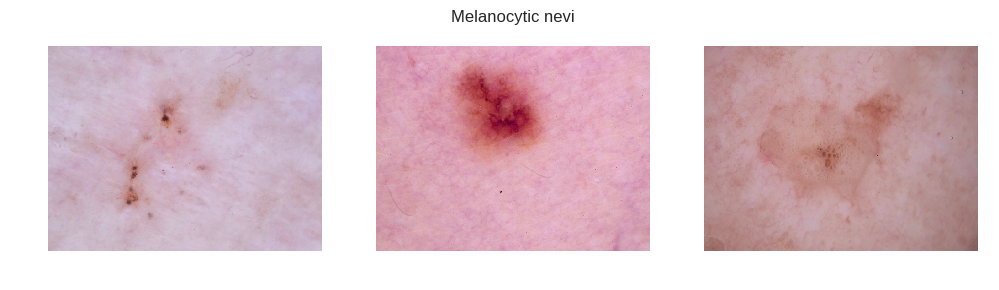

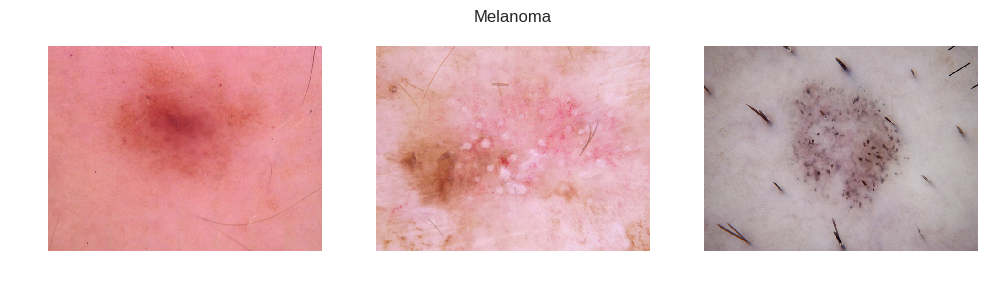

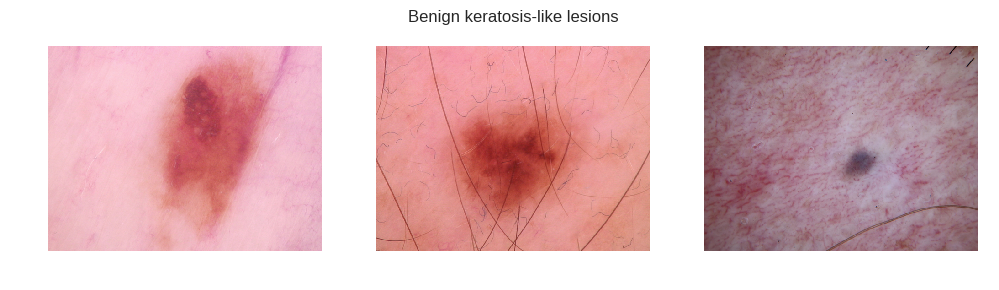

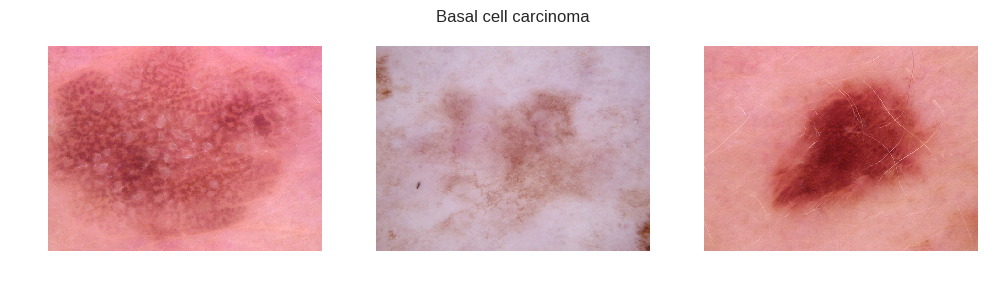

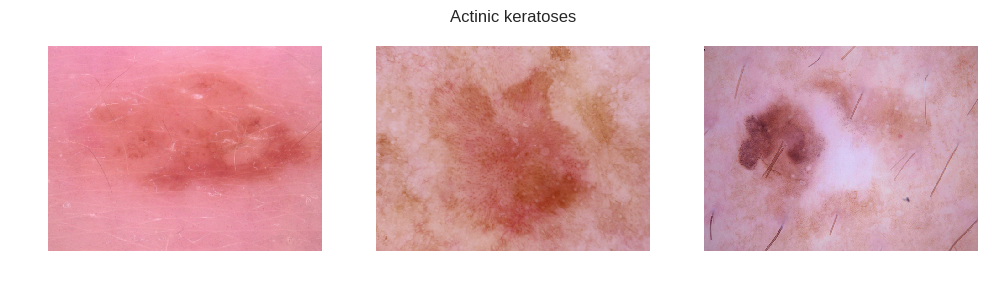

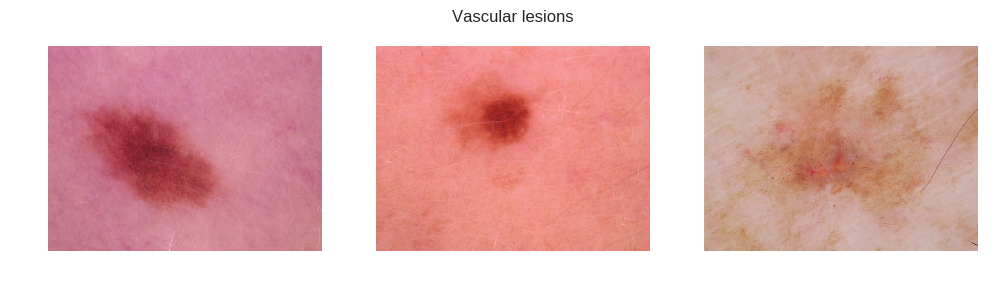

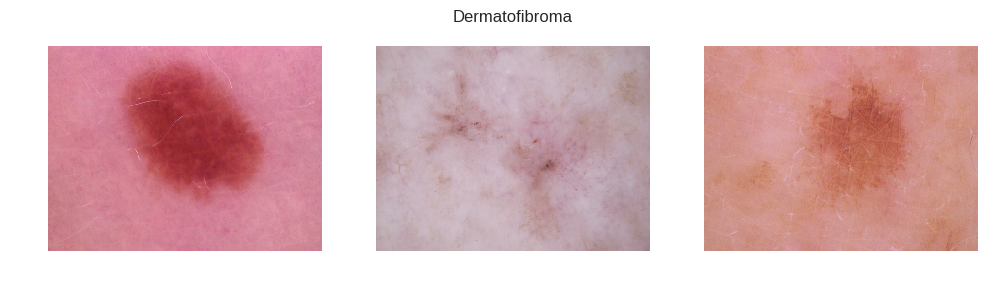

In [0]:
plot_array_sub()

In [0]:
# as the size of the above image is 450 x 600, it is too big for our model,
# let's decrease it's size and resize it to 75 x 100

In [0]:
start_time = time.clock()
    
# train
img_train = []
for n in range(0, len(images_1_train)):
    img_train.append(resize(images_1_train[n], (75, 100)))
    
# test
img_test = []
for n in range(0, len(images_1_test)):
    img_test.append(resize(images_1_test[n], (75, 100)))
    
print(time.clock() - start_time, "seconds")

276.176963 seconds


In [0]:
from IPython.display import Audio
import numpy as np

#Create a sound
framerate = 24100
t = np.linspace(0, 2, framerate * 2)
data = np.sin(2 * np.pi * 220 * t) + np.sin(2 * np.pi * 224 * t)

# Generate a player for mono sound
Audio(data, rate = framerate, autoplay = True)

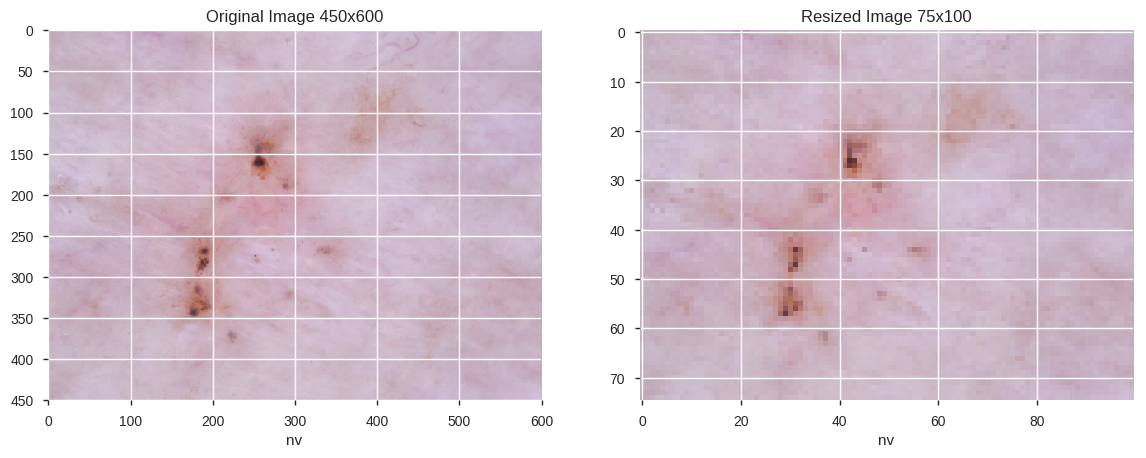

In [0]:
plt.figure(figsize = (14, 14))

plt.subplot(1, 2, 1)
plt.imshow(images_1_train[0])
plt.xlabel(train.dx.tolist()[0])
plt.title('Original Image 450x600')

plt.subplot(1, 2, 2)
plt.imshow(img_train[0])
plt.xlabel(train.dx.tolist()[0])
plt.title('Resized Image 75x100')
plt.show()

In [0]:
# the resized image is blurry

In [0]:
# now it's small
print('original image memory size: ', images_1_train[10].size, '\nreshaped image memory size:  ', img_train[10].size)

original image memory size:  810000 
reshaped image memory size:   22500


In [0]:
# let's make train and test

In [0]:
# train
X_train = np.array(img_train)
#y_train = y_train.reshape(y_train[0], -1)

# test
X_test = np.array(img_test)
#y_test = y_test.reshape(y_test[0], -1)

# also change y_test and y_train shape to include label size which is 7
y_train = np_utils.to_categorical(y_train, 7)
y_test = np_utils.to_categorical(y_test, 7)

In [0]:
print(X_train.shape , y_train.shape, X_test.shape , y_test.shape)

(5000, 75, 100, 3) (5000, 7) (5015, 75, 100, 3) (5015, 7)


In [0]:
# Let's build our CNN model

In [0]:
input_shape = (75, 100, 3)
num_classes = 7

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(100, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape, padding = 'Same'))
model.add(tf.keras.layers.Conv2D(100, (3, 3), activation = 'relu', padding = 'Same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(100, (3, 3), activation = 'relu', padding = 'Same'))
model.add(tf.keras.layers.Conv2D(100, (3, 3), activation = 'relu', padding = 'Same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(100, (3, 3), activation = 'relu', padding = 'Same'))
model.add(tf.keras.layers.Conv2D(100, (3, 3), activation = 'relu', padding = 'Same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(100, (3, 3), activation = 'relu', padding = 'Same'))
model.add(tf.keras.layers.Conv2D(100, (3, 3), activation = 'relu', padding = 'Same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes, activation = 'softmax'))
#model.add(Dense(num_classes, activation = tf.nn.softmax))

In [0]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [0]:
import tensorflow as tf
# This address identifies the TPU we'll use when configuring TensorFlow.
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.124.137.162:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 7249710864267747021)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 2603225411961291673)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 10653918451117186705)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 15827103144055479559)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 15783945813050516809)
INFO:tensorflow:*** Available Device: _Dev

In [0]:
tpu_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    (None, 75, 100, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 75, 100, 100)      2800      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 100, 100)      90100     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 50, 100)       0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 50, 100)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 50, 100)       90100     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 50, 100)       90100     
__________

In [0]:
batch_size = 1000
epochs = 30
#early_stopping_monitor = EarlyStopping(patience = 3)
# The argument patience is how many epochs a model can go without immediately before we stop training.

tpu_model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, verbose = 1, validation_data = (X_test, y_test))
         #callbacks = [early_stopping_monitor])

Train on 5000 samples, validate on 5015 samples
Epoch 1/30
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(125,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(125, 75, 100, 3), dtype=tf.float32, name='conv2d_input_10'), TensorSpec(shape=(125, 7), dtype=tf.float32, name='dense_1_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for conv2d_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7f483c298dd8> [<tf.Variable 'tpu_139948230433256/Adam/iterations:0' shape=() dtype=int64>, <tensorflow.contrib.tpu.python.tpu.keras_tpu_variables.ReplicatedVariable object at 0x7f483b064f98>, <tensorflow.contrib.tpu.python.tpu.keras_tpu_variables.ReplicatedVariable object at 0x7f483b00ba20>, <tensorflow.contrib.tpu.python.tpu.keras_tpu_variables.ReplicatedVariable object at 0x7f483b00bc18>, <tensorflow.contrib.tpu.python.tpu.keras_tpu_variables.ReplicatedVaria

In [0]:
keras.backend.clear_session()

In [0]:
score = model.evaluate(X_test, y_test, verbose = 1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

5015/5015 [==============================] - 8s 2ms/step
Test loss: 1.0643936226636557
Test accuracy: 0.6863409769499409


In [0]:
from keras.models import load_model
model.save('my_model.h5')

my_model = load_model('my_model.h5')

In [0]:
prediction = my_model.predict(np.array(img_test[0:4]))
probability_true = prediction[:,1]

In [0]:
prediction